In [3]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

ModuleNotFoundError: No module named 'sklearn'

In [3]:
df = pd.read_csv('loan_data_cleaned.csv')

In [5]:
# Feature 1: Credit risk adjusted by loan amount
df['Credit_Loan_Ratio'] = df['Credit_History'] * df['Log_LoanAmount']

# Feature 2: Socioeconomic stability
df['Married_Educated'] = df['Married'] * df['Education']

# Feature 3: Family burden indicator
df['SelfEmp_Dependents'] = df['Self_Employed'] * df['Dependents']

# Feature 4: Burden of EMI relative to income
df['Term_Income_Ratio'] = df['Loan_Amount_Term'] / df['Log_Total_Income']

# Feature 5: Bucket loan size
# Safe binning: include lower edge and right-most value
df['LoanAmount_Bin'] = pd.cut(
    df['Log_LoanAmount'],
    bins=[0, 3, 3.5, 5],
    labels=[0, 1, 2],
    include_lowest=True,
    right=True
)

# Convert to int safely: fill NaNs first (optional strategy: fill with mode or -1)
df['LoanAmount_Bin'] = df['LoanAmount_Bin'].astype(float)  # convert to float first
df['LoanAmount_Bin'] = df['LoanAmount_Bin'].fillna(-1).astype(int)  # fill NaNs and cast to int



In [6]:
# Drop target column and re-define X, y
X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [7]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report

cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.03,
    depth=5,
    class_weights=[2, 1],  # Give more weight to class 0
    random_seed=42,
    verbose=0
)

cat_model.fit(X_train, y_train)

# Predict with threshold
cat_proba = cat_model.predict_proba(X_test)[:, 1]
cat_thresh = 0.36  # best threshold from your earlier tuning
cat_pred = (cat_proba >= cat_thresh).astype(int)

print("CatBoost Results:")
print(classification_report(y_test, cat_pred))


CatBoost Results:
              precision    recall  f1-score   support

           0       0.85      0.61      0.71        38
           1       0.84      0.95      0.90        85

    accuracy                           0.85       123
   macro avg       0.85      0.78      0.80       123
weighted avg       0.85      0.85      0.84       123



In [8]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.03,
    scale_pos_weight=43 / 80,  # class 0 / class 1
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train, y_train)

xgb_proba = xgb_model.predict_proba(X_test)[:, 1]
xgb_pred = (xgb_proba >= cat_thresh).astype(int)  # use same threshold

print("XGBoost Results:")
print(classification_report(y_test, xgb_pred))

XGBoost Results:
              precision    recall  f1-score   support

           0       0.84      0.55      0.67        38
           1       0.83      0.95      0.89        85

    accuracy                           0.83       123
   macro avg       0.83      0.75      0.78       123
weighted avg       0.83      0.83      0.82       123



/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:59:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [9]:
avg_proba = (cat_proba + xgb_proba) / 2
ensemble_pred = (avg_proba >= cat_thresh).astype(int)

print("Ensemble Results:")
print(classification_report(y_test, ensemble_pred))

Ensemble Results:
              precision    recall  f1-score   support

           0       0.84      0.55      0.67        38
           1       0.83      0.95      0.89        85

    accuracy                           0.83       123
   macro avg       0.83      0.75      0.78       123
weighted avg       0.83      0.83      0.82       123



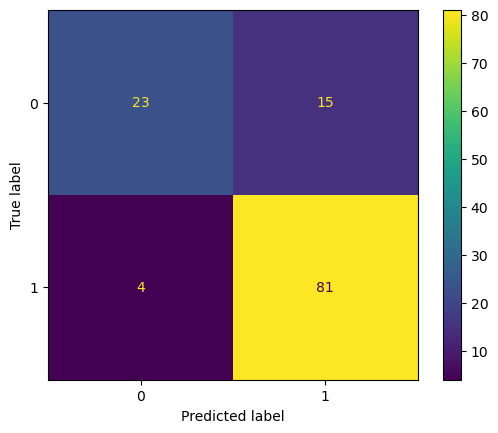

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, cat_pred)
ConfusionMatrixDisplay(cm).plot()


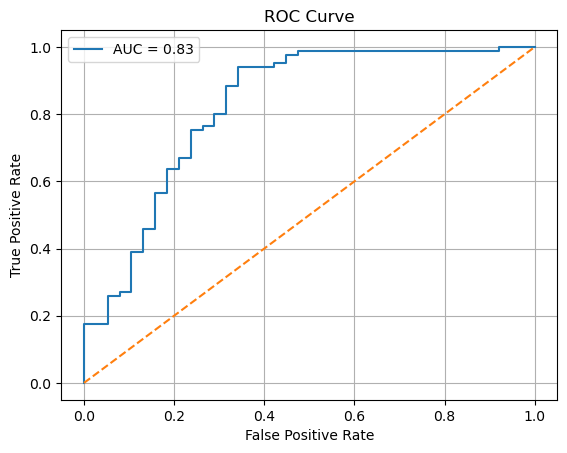

In [17]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()
